<a href="https://colab.research.google.com/github/UERJ-FISICA/ML4PPGF_UERJ/blob/PPGF-2023-2/Peak_Finding_with_Clustering_CMB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Adaptado de D. Ayres Rocha

Link para baixar os mapas de dados CMB (arquivos `.fits`):
https://pla.esac.esa.int/pla/#maps

In [ ]:
!pip install healpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 60.9 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm, rcParams
import numpy as np
import healpy as hp
import pandas as pd
import os
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
import glob
from PIL import Image
from google.colab import drive # Comentar se for rodar localmente no computador

In [ ]:
# Comentar as duas proximas linhas se for rodar localmente no computador
drive.mount('/content/drive')
%cd /content/drive/My Drive/workspace/data-analysis/data/planck
%ls

Mounted at /content/drive
/content/drive/My Drive/workspace/data-analysis/data/planck
fits/                    PartMapAnalysis_KMEANS/  PlanckMaps_CMB.png  PlanckMaps.png
PartMapAnalysis_DBScan/  PlanckMaps_CMB_LOG.png   PlanckMaps_LOG.png


In [ ]:
freqs       = [30, 44, 70, 100, 143, 217, 353, 545, 857] # Frequências dos mapas dispoíveis da colaboração
FitsFolder  = "fits"
filesList   = os.listdir(FitsFolder)
print(filesList)

FitsList    = []
for freq in freqs:
    for file in filesList:
        if (str(freq) in file):
            FitsList.append(os.path.join(FitsFolder,file))
            break

CMBFile = None
for file in filesList:
    if ("CMB" in file):
        CMBFile = os.path.join(FitsFolder,file)
        break

print ( FitsList )
print ( CMBFile )

['LFI_SkyMap_030-BPassCorrected-field-IQU_1024_R3.00_full.fits', 'LFI_SkyMap_044-BPassCorrected-field-IQU_1024_R3.00_full.fits', 'LFI_SkyMap_070-BPassCorrected-field-IQU_1024_R3.00_full.fits', 'HFI_SkyMap_100-field-IQU_2048_R3.00_full.fits', 'HFI_SkyMap_217-field-IQU_2048_R3.00_full.fits', 'HFI_SkyMap_353-psb-field-IQU_2048_R3.00_full.fits', 'HFI_SkyMap_143-field-IQU_2048_R3.00_full.fits', 'HFI_SkyMap_545-field-Int_2048_R3.00_full.fits', 'HFI_SkyMap_857-field-Int_2048_R3.00_full.fits', 'COM_CMB_IQU-smica_2048_R3.00_full.fits', 'extra']
['fits/LFI_SkyMap_030-BPassCorrected-field-IQU_1024_R3.00_full.fits', 'fits/LFI_SkyMap_044-BPassCorrected-field-IQU_1024_R3.00_full.fits', 'fits/LFI_SkyMap_070-BPassCorrected-field-IQU_1024_R3.00_full.fits', 'fits/HFI_SkyMap_100-field-IQU_2048_R3.00_full.fits', 'fits/HFI_SkyMap_143-field-IQU_2048_R3.00_full.fits', 'fits/HFI_SkyMap_217-field-IQU_2048_R3.00_full.fits', 'fits/HFI_SkyMap_353-psb-field-IQU_2048_R3.00_full.fits', 'fits/HFI_SkyMap_545-field-Int

In [ ]:
! ls -lah fits

total 5.0G
-rw------- 1 root root 1.9G Nov  8 18:07 COM_CMB_IQU-smica_2048_R3.00_full.fits
drwx------ 2 root root 4.0K Nov  8 19:31 extra
-rw------- 1 root root 577M Nov  8 17:51 HFI_SkyMap_100-field-IQU_2048_R3.00_full.fits
-rw------- 1 root root 577M Nov  8 17:52 HFI_SkyMap_143-field-IQU_2048_R3.00_full.fits
-rw------- 1 root root 577M Nov  8 17:51 HFI_SkyMap_217-field-IQU_2048_R3.00_full.fits
-rw------- 1 root root 577M Nov  8 17:51 HFI_SkyMap_353-psb-field-IQU_2048_R3.00_full.fits
-rw------- 1 root root 193M Nov  8 17:54 HFI_SkyMap_545-field-Int_2048_R3.00_full.fits
-rw------- 1 root root 193M Nov  8 17:54 HFI_SkyMap_857-field-Int_2048_R3.00_full.fits
-rw------- 1 root root 145M Nov  8 17:48 LFI_SkyMap_030-BPassCorrected-field-IQU_1024_R3.00_full.fits
-rw------- 1 root root 145M Nov  8 17:48 LFI_SkyMap_044-BPassCorrected-field-IQU_1024_R3.00_full.fits
-rw------- 1 root root 145M Nov  8 17:49 LFI_SkyMap_070-BPassCorrected-field-IQU_1024_R3.00_full.fits


<ipython-input-6-1e7ee5872065>:3: RuntimeWarning: invalid value encountered in log
  hp.mollview(np.log(img), title="CMB plot [LOG Scale]", nest=True)


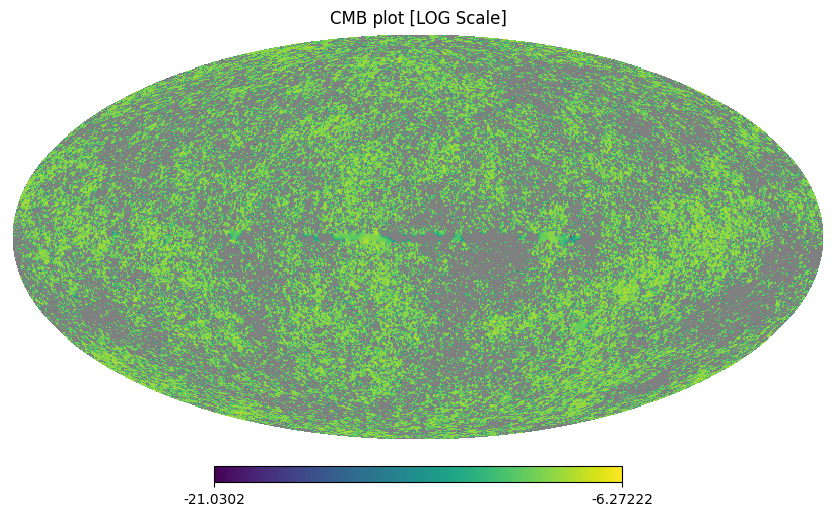

In [ ]:
# Carregando CMB e plotando [Escala Logarítmica]
img = hp.fitsfunc.read_map(CMBFile, nest=True)
hp.mollview(np.log(img), title="CMB plot [LOG Scale]", nest=True)
plt.show(block=False)
plt.tight_layout()
plt.savefig('PlanckMaps_CMB_LOG.png')
plt.close()

In [ ]:
# Carregando Mapas de frequência e plotando em um único canvas [Escala Logarítmica]
# fig,  ([ax0, ax1, ax2], [ax3, ax4, ax5], [ax6, ax7, ax8]) = plt.subplots(nrows=3, ncols=3, figsize=(1920/600, 1080/600), dpi=600)
fig,  axes = plt.subplots(nrows=3, ncols=3, figsize=(3*(1920/600), 3*(1080/600)), dpi=600)
axes__ = axes.flatten()
for i, file in enumerate(FitsList):
    img = hp.fitsfunc.read_map(file, nest=True)
    # eval("plt.axes(ax%d)"%(i))
    plt.sca( axes__[ i ] )
    hp.mollview(np.log(img), title="Temp Flutuation for Freq=%dGHz [LOG Scale]"%(freqs[i]), nest=True, hold=True)
    # plt.show(block=False)
plt.show()
plt.savefig('PlanckMaps_LOG.png')
plt.close()

mkdir: cannot create directory ‘PartMapAnalysis_KMEANS’: File exists
mkdir: cannot create directory ‘PartMapAnalysis_KMEANS/FREQ30_-5-lat-5_10-long-20’: File exists
            theta       phi         I
4505567  1.657493  0.297592  0.001177
4505583  1.657493  0.291456  0.001291
4505587  1.657493  0.294524  0.001145
4505588  1.657493  0.296058  0.001135
4505589  1.656840  0.296825  0.001295
...           ...       ...       ...
4685834  1.484753  0.292223  0.001297
4685835  1.484099  0.292990  0.001222
4685836  1.484099  0.294524  0.001341
4685840  1.484099  0.297592  0.001171
4685856  1.484099  0.291456  0.001211

[30305 rows x 3 columns]
(0.2615437243345018, 0.05026065106579693) (1.5707963267948966, 0.05021833494735595) (-5.500425, 1.0257910819235239)
            theta       phi         I
4505567  1.726403  0.717232 -1.213420
4505583  1.726403  0.595150 -1.122893
4505587  1.726403  0.656191 -1.239968
4505588  1.726403  0.686712 -1.248888
4505589  1.713391  0.701972 -1.119863
...      

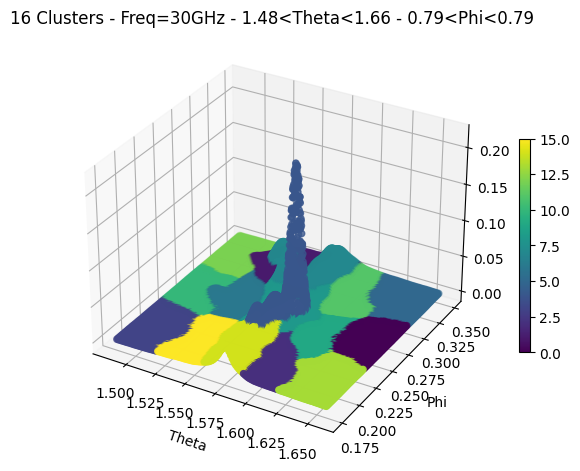

<ipython-input-16-a565268d4142>:67: RuntimeWarning: invalid value encountered in log
  hp.cartview(np.log(img), title="Temp Flutuation for Freq=%dGHz [LOG Scale]"%(freqs[i]), latra=[-5,5], lonra=[10,20], nest=True, hold=True)
<ipython-input-16-a565268d4142>:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.clusters[df_sliced[pos:pos+1:].index[0]]=Clusters[pos]


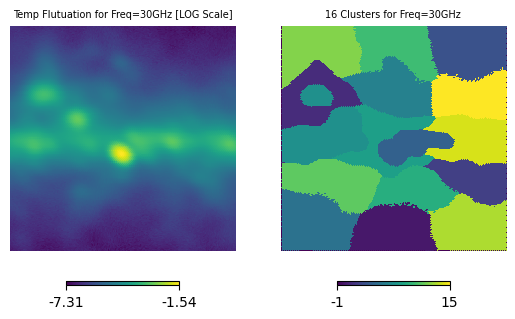


Clusters criados pelo K-Means para NClusters=16

[[ 1.41055789  0.01496387 -1.0852959 ]
 [-0.63117752  1.22062683  0.69030157]
 [ 0.64044707 -1.22936004  0.30926353]
 [-1.35133201 -1.14774147 -1.11591532]
 [ 0.11084983 -0.27606922  2.19875852]
 [ 1.31294585  1.22004669 -0.88570813]
 [-0.73466005  0.01344446  0.0449591 ]
 [-0.09600601  1.08482869  1.59058654]
 [ 0.03998791  0.13694642  0.99614208]
 [ 0.80457304 -0.31015039 -0.25681197]
 [-1.3747072  -0.04448152 -0.8267701 ]
 [ 0.68424135  0.92977692  0.01109498]
 [-1.35107914  1.15104633 -0.61102995]
 [ 1.35498584 -1.16311362 -0.81060172]
 [ 0.02309607 -1.19110049  1.34801446]
 [-0.6374576  -1.17917442 -0.0075011 ]]
[[ 0.33243928  1.57154779 -6.61371172]
 [ 0.22982033  1.63209417 -4.79231967]
 [ 0.29373301  1.50905991 -5.18318509]
 [ 0.1936249   1.51315866 -6.64512085]
 [ 0.26711511  1.55693259 -3.24495798]
 [ 0.32753324  1.63206504 -6.40897636]
 [ 0.22461923  1.57147149 -5.45430622]
 [ 0.2567184   1.62527462 -3.86881537]
 [ 0.26355354

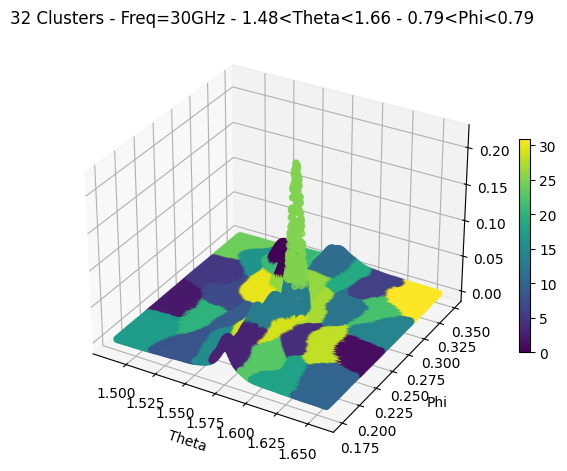

<ipython-input-16-a565268d4142>:67: RuntimeWarning: invalid value encountered in log
  hp.cartview(np.log(img), title="Temp Flutuation for Freq=%dGHz [LOG Scale]"%(freqs[i]), latra=[-5,5], lonra=[10,20], nest=True, hold=True)
<ipython-input-16-a565268d4142>:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.clusters[df_sliced[pos:pos+1:].index[0]]=Clusters[pos]


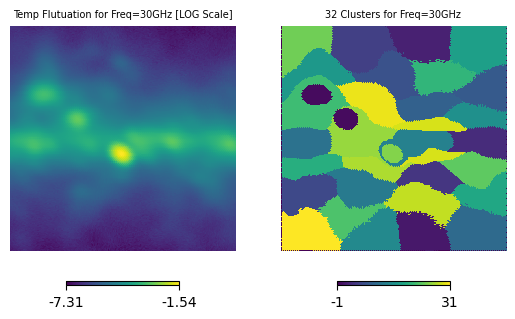


Clusters criados pelo K-Means para NClusters=32

[[-4.93612967e-01  9.88219701e-01  1.86627669e+00]
 [ 1.45997366e+00 -4.13356514e-01 -1.06832490e+00]
 [-1.47472793e+00 -4.31812530e-01 -1.11796808e+00]
 [ 6.06146349e-02 -1.34211770e+00  1.65923603e+00]
 [ 6.01581897e-01 -5.63258907e-01  1.09923120e-01]
 [-1.41024804e+00  5.19301653e-01 -7.48235233e-01]
 [ 8.44757898e-01  1.33791274e+00 -4.37745585e-01]
 [-9.62050067e-01  2.87416187e-02 -2.25786105e-01]
 [-7.45603611e-01 -1.42483859e+00 -2.26531450e-01]
 [-4.89086970e-01 -4.94919560e-01  2.64218506e-01]
 [ 1.42480997e+00 -1.26990762e+00 -8.91457908e-01]
 [ 7.83623325e-02  1.36758607e+00  1.64334223e+00]
 [ 7.70016345e-01  5.03560235e-01 -3.61035003e-02]
 [ 7.85556611e-02 -3.63244715e-01  1.98831893e+00]
 [ 1.47545239e+00  2.94182203e-01 -1.16726110e+00]
 [-3.31143851e-01 -1.27059070e+00  6.47449218e-01]
 [-1.02299583e+00  1.20099327e+00  2.48227116e-02]
 [-1.40230112e+00 -1.30054013e+00 -1.17851572e+00]
 [ 8.92827532e-01 -1.40611057e+0

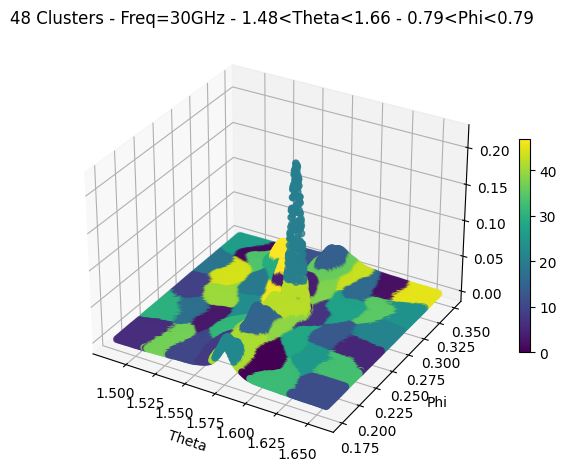

<ipython-input-16-a565268d4142>:67: RuntimeWarning: invalid value encountered in log
  hp.cartview(np.log(img), title="Temp Flutuation for Freq=%dGHz [LOG Scale]"%(freqs[i]), latra=[-5,5], lonra=[10,20], nest=True, hold=True)
<ipython-input-16-a565268d4142>:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.clusters[df_sliced[pos:pos+1:].index[0]]=Clusters[pos]


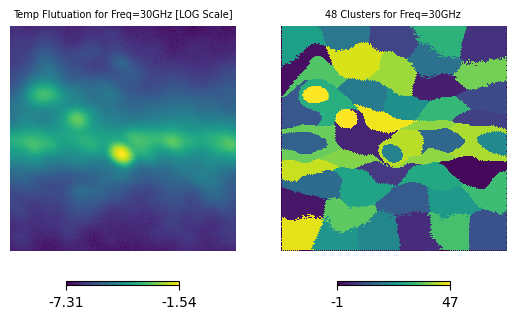


Clusters criados pelo K-Means para NClusters=48

[[ 5.04580343e-01 -1.23728185e+00  6.29548618e-01]
 [-1.13016647e+00  1.42236994e+00 -2.93905176e-01]
 [ 1.03704828e+00  1.43460938e+00 -6.73920116e-01]
 [-7.81856510e-01 -6.52042347e-01 -3.08541753e-01]
 [ 8.10930019e-04  5.07183497e-01  1.56394345e+00]
 [ 1.45549931e+00 -3.35256683e-01 -1.10941339e+00]
 [-1.45285377e+00 -1.38230708e+00 -1.22757208e+00]
 [ 5.32224722e-01  1.13685574e-01  4.33207437e-01]
 [-2.95777679e-01 -1.35042617e+00  7.14833084e-01]
 [-1.51716516e+00  4.31046048e-03 -9.37050565e-01]
 [-6.15204008e-01 -1.42668609e+00 -1.74817499e-02]
 [ 1.43691474e+00 -1.44312097e+00 -9.08578399e-01]
 [-4.11891691e-01  1.48967102e+00  7.52237878e-01]
 [ 9.52769969e-01 -1.70988176e-01 -5.99418099e-01]
 [ 6.93417782e-02  1.40075768e+00  1.84205117e+00]
 [ 3.45536929e-02 -7.27162295e-01  1.90945254e+00]
 [ 7.24940561e-01  1.18470979e+00 -2.88125368e-01]
 [-1.16733756e+00 -5.92156018e-01 -8.32808484e-01]
 [-1.57018765e+00  7.59797420e-0

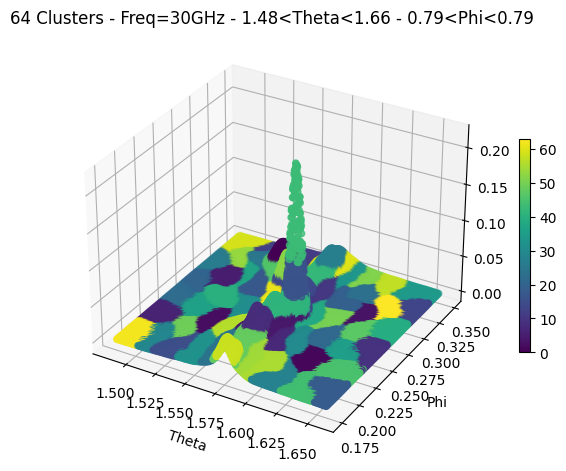

<ipython-input-16-a565268d4142>:67: RuntimeWarning: invalid value encountered in log
  hp.cartview(np.log(img), title="Temp Flutuation for Freq=%dGHz [LOG Scale]"%(freqs[i]), latra=[-5,5], lonra=[10,20], nest=True, hold=True)
<ipython-input-16-a565268d4142>:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.clusters[df_sliced[pos:pos+1:].index[0]]=Clusters[pos]


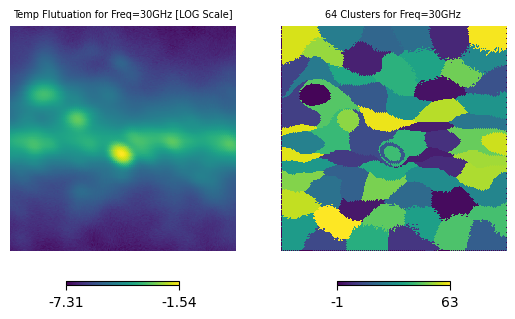


Clusters criados pelo K-Means para NClusters=64

[[-0.66616715  1.22387252  1.73355266]
 [ 0.99945442 -0.89317974 -0.4579544 ]
 [-0.74265916 -0.68223628 -0.23293729]
 [ 1.08951368  0.54892747 -0.39846102]
 [ 0.04108151 -0.51617207  1.27735573]
 [-1.21057859  0.47658021 -0.53448086]
 [-1.49386783 -0.85503944 -1.28970471]
 [ 0.41215233 -0.77910923  0.65615413]
 [ 0.03567046 -0.7336695   1.99456966]
 [ 1.5748476  -0.22070852 -1.24187652]
 [ 0.31499446  0.70180126  0.88929489]
 [-0.41597836  1.48480476  0.76504671]
 [-1.01070182  1.56408852 -0.29733711]
 [ 1.5993822   1.08374258 -1.22549115]
 [ 0.01948671  0.39430153  1.54337464]
 [-0.84645245 -1.48921385 -0.35696012]
 [ 0.23004259  0.03417793  2.55931202]
 [-0.64882735  0.40811335  0.43389291]
 [ 1.53586779 -1.40277801 -1.01546464]
 [ 0.66346715  0.69065048  0.05517568]
 [-1.52141464  0.19247035 -0.84163538]
 [ 0.8938588  -0.26403069 -0.5448691 ]
 [-1.55216728 -0.29632093 -1.13481859]
 [ 0.81987131  1.04560221 -0.42930401]
 [-0.24526988 

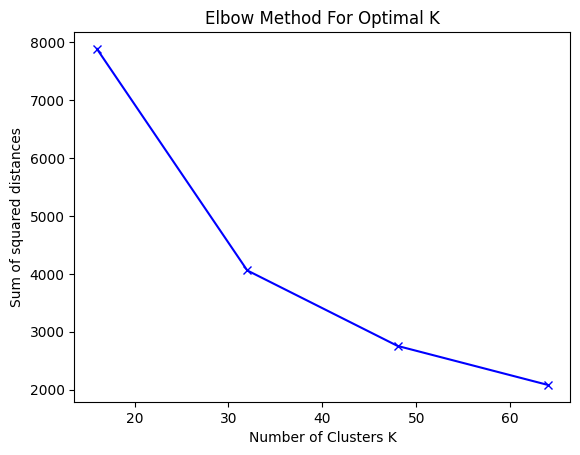

In [ ]:
# Análise de uma região selecionada com K-Means (região com picos bem definidos)
i = 0
OutFolderName = 'FREQ%d_-5-lat-5_10-long-20'%(freqs[i])
try:
    !mkdir "PartMapAnalysis_KMEANS"     # Para rodar no google colab
    #os.mkdir("PartMapAnalysis_KMEANS") # Para rodar localmente no computador
except:
    print('Folder \"PartMapAnalysis_KMEANS\" already exists...')
try:
    !mkdir 'PartMapAnalysis_KMEANS/'$OutFolderName                  # Para rodar no google colab
    #os.mkdir(os.path.join('PartMapAnalysis_KMEANS',OutFolderName)) # Para rodar localmente no computador
except:
    print('Folder \"'+OutFolderName+'\" already exists...')
img         = hp.fitsfunc.read_map(FitsList[i], nest=True)
nside       = hp.pixelfunc.npix2nside(len(img)) # Obtendo o NSide a partir do número de pixels dos mapas
thetaLoc    = [1.4834457030421433, 1.6581469505476498]
phiLoc      = [0.17410681942502026, 0.3489806292439833]
theta, phi  = hp.fitsfunc.pixelfunc.pix2ang(nside,np.arange(len(img)), nest=True) # Obtendo o Theta e Phi a partir do pixel (ra = phi | 90 - dec = theta)
d           = {'theta': theta, 'phi': phi, 'I': img.byteswap().newbyteorder()}
df          = pd.DataFrame(data=d)
df_sliced   = df[(df.theta > thetaLoc[0]) & (df.theta < thetaLoc[1]) & (df.phi > phiLoc[0]) & (df.phi < phiLoc[1])]
print ( df_sliced )
df_sliced_norm = df_sliced.copy()
def norm_df( df_norm ):
    df_norm.loc[ :, "I" ] = np.log( df_norm.loc[ :, "I" ] ) # log
    phi_   = df_norm.loc[ :, "phi" ]
    theta_ = df_norm.loc[ :, "theta" ]
    I_     = df_norm.loc[ :, "I" ]
    mean_phi_   = np.mean( phi_ )
    mean_theta_ = np.mean( theta_ )
    mean_I_     = np.mean( I_ )
    sig_phi_    = np.sqrt( np.mean( phi_ ** 2 ) -  mean_phi_ ** 2 )
    sig_theta_  = np.sqrt( np.mean( theta_ ** 2 ) -  mean_theta_ ** 2 )
    sig_I_      = np.sqrt( np.mean( I_ ** 2 ) -  mean_I_ ** 2 )
    df_norm.loc[ :, "phi" ] = ( df_norm.loc[ :, "phi" ] - mean_phi_ ) / sig_phi_
    df_norm.loc[ :, "theta" ] = ( df_norm.loc[ :, "theta" ] - mean_theta_ ) / sig_theta_
    df_norm.loc[ :, "I" ] = ( df_norm.loc[ :, "I" ] - mean_I_ ) / sig_I_
    return ( (mean_phi_,sig_phi_), (mean_theta_,sig_theta_), (mean_I_,sig_I_) ) # to correct values back

(mean_phi,sig_phi), (mean_theta,sig_theta), (mean_I,sig_I) = norm_df( df_sliced_norm )
print ( (mean_phi,sig_phi), (mean_theta,sig_theta), (mean_I,sig_I) )
print ( df_sliced_norm )
print ( df_sliced_norm.values )

# Obtendo o número de clusters ótimo da partir da curva:
Sum_of_squared_distances = []
# K = range(1,25)
K = range(16,80,16)
for k in K:
    kmeans  = KMeans(n_clusters = k, init = 'k-means++', n_init = 10, max_iter = 300)
    Clusters  = kmeans.fit_predict(df_sliced_norm.values)
    Sum_of_squared_distances.append(kmeans.inertia_)
    fig2    = plt.figure()
    ax      = fig2.add_subplot(projection='3d')
    p       = ax.scatter(df_sliced.theta.values, df_sliced.phi.values, df_sliced.I.values, c = Clusters, marker='o')
    plt.colorbar(p, shrink=0.5)
    plt.title('%d Clusters - Freq=%dGHz - %.2f<Theta<%.2f - %.2f<Phi<%.2f '%(k,freqs[i],thetaLoc[0],thetaLoc[1],phi[0],phi[1]))
    ax.set_xlabel('Theta')
    ax.set_ylabel('Phi')
    ax.set_zlabel('I')
    plt.tight_layout()
    plt.savefig(os.path.join('PartMapAnalysis_KMEANS',OutFolderName,'Part_%dClustersFreq%d_%.2ftheta%.2f_%.2fphi%.2f.png'%(k,freqs[i],thetaLoc[0],thetaLoc[1],phi[0],phi[1])))
    plt.show(block=False)
    plt.close()
    fig3,  ([ax0, ax1]) = plt.subplots(nrows=1, ncols=2)
    plt.axes(ax0)
    hp.cartview(np.log(img), title="Temp Flutuation for Freq=%dGHz [LOG Scale]"%(freqs[i]), latra=[-5,5], lonra=[10,20], nest=True, hold=True)
    plt.axes(ax1)
    df["clusters"]=np.ones(len(img))*(-1)
    for pos in range(len(df_sliced)):
        df.clusters[df_sliced[pos:pos+1:].index[0]]=Clusters[pos]
    hp.cartview(df.clusters.values, title="%d Clusters for Freq=%dGHz"%(k,freqs[i]), latra=[-5,5], lonra=[10,20], nest=True, hold=True)
    fig3.get_children()[1].get_children()[8].set_fontsize(7)
    fig3.get_children()[3].get_children()[8].set_fontsize(7)
    plt.savefig(os.path.join('PartMapAnalysis_KMEANS',OutFolderName,'Part_%dClustersFreq%d_%.2ftheta%.2f_%.2fphi%.2f_ComparisonView.png'%(k,freqs[i],thetaLoc[0],thetaLoc[1],phi[0],phi[1])))
    plt.show()
    print("\nClusters criados pelo K-Means para NClusters=%d\n"%(k))
    print(kmeans.cluster_centers_)
    # Correct back
    mean_ = np.array( (mean_phi, mean_theta, mean_I ) )
    sig_  = np.array( (sig_phi, sig_theta, sig_I ) )
    clusters_corrected_ = ( kmeans.cluster_centers_ * sig_ + mean_ )
    print ( clusters_corrected_ )

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('Number of Clusters K')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal K')
plt.show(block=False)
plt.savefig(os.path.join('PartMapAnalysis_KMEANS',OutFolderName,'elbow_part_Freq%d_-5lat5_10long20.png'%(freqs[i])))
plt.close()

In [ ]:
# Análise de todos os mapas de frequência em partes
for i, file in enumerate(FitsList):
    # Varrendo o espaço de pi/16 em pi/16 para theta e phi com 1% de margem para evitar efeito de bordas
    for thetaVal in range(0,16):
        for phiVal in range (0,32):
            # Obtendo os limites de theta e phi
            ThetaL  = (0.99*thetaVal*np.pi)/16
            ThetaH  = (1.01*(thetaVal+1)*np.pi)/16
            PhiL    = (0.99*phiVal*np.pi)/16
            PhiH    = (1.01*(phiVal+1)*np.pi)/16
            OutFolderName = 'FREQ%d_%.2f-Theta-%.2f_%.2f-Phi-%.2f'%(freqs[i],ThetaL,ThetaH,PhiL,PhiH)
            try:
                !mkdir 'PartMapAnalysis_KMEANS/'$OutFolderName                  # Para rodar no google colab
                #os.mkdir(os.path.join('PartMapAnalysis_KMEANS',OutFolderName)) # Para rodar localmente no computador
            except:
                print('Folder \"'+OutFolderName+'\" already exists...')
            img     = hp.fitsfunc.read_map(FitsList[i], nest=True)
            nside   = hp.pixelfunc.npix2nside(len(img)) # Obtendo o NSide a partir do número de pixels dos mapas
            theta, phi  = hp.fitsfunc.pixelfunc.pix2ang(nside,np.arange(len(img)), nest=True) # Obtendo o Theta e Phi a partir do pixel (ra = phi | 90 - dec = theta)
            d       = {'theta': theta, 'phi': phi, 'I': img.byteswap().newbyteorder()}
            df      = pd.DataFrame(data=d)
            df_sliced   = df[(df.theta > ThetaL) & (df.theta < ThetaH) & (df.phi > PhiL) & (df.phi < PhiH)]

            (mean_phi,sig_phi), (mean_theta,sig_theta), (mean_I,sig_I) = norm_df( df_sliced_norm )
            print ( (mean_phi,sig_phi), (mean_theta,sig_theta), (mean_I,sig_I) )
            print ( df_sliced_norm )
            print ( df_sliced_norm.values )

            # Obtendo o número de clusters ótimo da partir da curva:
            Sum_of_squared_distances = []
            # K = range(1,30)
            K = range(16,80,16)
            for k in K:
                kmeans  = KMeans(n_clusters = k, init = 'k-means++', n_init = 10, max_iter = 300)
                Clusters  = kmeans.fit_predict(df_sliced_norm.values)
                Sum_of_squared_distances.append(kmeans.inertia_)
                fig2    = plt.figure()
                ax      = fig2.add_subplot(projection='3d')
                p       = ax.scatter(df_sliced.theta.values, df_sliced.phi.values, df_sliced.I.values, c = Clusters, marker='o')
                plt.colorbar(p, shrink=0.5)
                plt.title('%d Clusters - Freq=%dGHz - %.2f<Theta<%.2f - %.2f<Phi<%.2f '%(k,freqs[i],ThetaL,ThetaH,PhiL,PhiH))
                ax.set_xlabel('Theta')
                ax.set_ylabel('Phi')
                ax.set_zlabel('I')
                plt.tight_layout()
                plt.savefig(os.path.join('PartMapAnalysis_KMEANS',OutFolderName,'Part_%dClustersFreq%d_%.2ftheta%.2f_%.2fphi%.2f.png'%(k,freqs[i],ThetaL,ThetaH,PhiL,PhiH)))
                plt.show(block=False)
                plt.close()
                fig3,  ([ax0, ax1]) = plt.subplots(nrows=1, ncols=2)
                plt.axes(ax0)
                hp.mollview(np.log(img), title="Temp Flutuation for Freq=%dGHz [LOG Scale]"%(freqs[i]), nest=True, hold=True)
                plt.axes(ax1)
                df["clusters"]=np.ones(len(img))*(-1)
                for pos in range(len(df_sliced)):
                    df.clusters[df_sliced[pos:pos+1:].index[0]]=Clusters[pos]
                hp.mollview(df.clusters.values, title="%d Clusters for Freq=%dGHz"%(k,freqs[i]), nest=True, hold=True)
                fig3.get_children()[1].get_children()[8].set_fontsize(7)
                fig3.get_children()[3].get_children()[8].set_fontsize(7)
                plt.savefig(os.path.join('PartMapAnalysis_KMEANS',OutFolderName,'Part_%dClustersFreq%d_%.2ftheta%.2f_%.2fphi%.2f_ComparisonView.png'%(k,freqs[i],ThetaL,ThetaH,PhiL,PhiH)))
                plt.show(block=False)
                print("\nClusters criados pelo K-Means para NClusters=%d\n"%(k))
                print(kmeans.cluster_centers_)
                # Correct back
                mean_ = np.array( (mean_phi, mean_theta, mean_I ) )
                sig_  = np.array( (sig_phi, sig_theta, sig_I ) )
                clusters_corrected_ = ( kmeans.cluster_centers_ * sig_ + mean_ )
                print ( clusters_corrected_ )
                # Para ativar o parâmetro abaixo, mudar o range do número de clusters para começar em 2
                #silhouette_avg = silhouette_score(df_sliced.values, Clusters)
                #print("Para n_clusters =", k,"\nO score_silhouette médio é :", silhouette_avg)
            plt.plot(K, Sum_of_squared_distances, 'bx-')
            plt.xlabel('Number of Clusters K')
            plt.ylabel('Sum of squared distances')
            plt.title('Elbow Method For Optimal K')
            plt.savefig(os.path.join('PartMapAnalysis_KMEANS',OutFolderName,'elbow_part_Freq%d__%.2ftheta%.2f_%.2fphi%.2f.png'%(freqs[i],ThetaL,ThetaH,PhiL,PhiH)))
            plt.show(block=False)
            plt.close()

In [ ]:
# Análise do mapa de CMB em partes
# Varrendo o espaço de pi/16 em pi/16 para theta e phi com 1% de margem para evitar efeito de bordas
for thetaVal in range(0,16):
    for phiVal in range (0,32):
        img         = hp.fitsfunc.read_map(CMBFile, nest=True)
        nside       = hp.pixelfunc.npix2nside(len(img)) # Obtendo o NSide a partir do número de pixels dos mapas
        theta, phi  = hp.fitsfunc.pixelfunc.pix2ang(nside,np.arange(len(img)), nest=True) # Obtendo o Theta e Phi a partir do pixel (ra = phi | 90 - dec = theta)
        d       = {'theta': theta, 'phi': phi, 'I': img.byteswap().newbyteorder()}
        df      = pd.DataFrame(data=d)
        # Obtendo os limites de theta e phi
        ThetaL  = (0.99*thetaVal*np.pi)/16
        ThetaH  = (1.01*(thetaVal+1)*np.pi)/16
        PhiL    = (0.99*phiVal*np.pi)/16
        PhiH    = (1.01*(phiVal+1)*np.pi)/16
        OutFolderName = 'CMB_%.2f-Theta-%.2f_%.2f-Phi-%.2f'%(ThetaL,ThetaH,PhiL,PhiH)
        try:
            !mkdir 'PartMapAnalysis_KMEANS/'$OutFolderName                  # Para rodar no google colab
            #os.mkdir(os.path.join('PartMapAnalysis_KMEANS',OutFolderName)) # Para rodar localmente no computador
        except:
            print('Folder \"'+OutFolderName+'\" already exists...')
        df_sliced   = df[(df.theta > ThetaL) & (df.theta < ThetaH) & (df.phi > PhiL) & (df.phi < PhiH)]

        (mean_phi,sig_phi), (mean_theta,sig_theta), (mean_I,sig_I) = norm_df( df_sliced_norm )
        print ( (mean_phi,sig_phi), (mean_theta,sig_theta), (mean_I,sig_I) )
        print ( df_sliced_norm )
        print ( df_sliced_norm.values )

        # Obtendo o número de clusters ótimo da partir da curva:
        Sum_of_squared_distances = []
        # K = range(1,30)
        K = range(16,80,16)
        for k in K:
            kmeans  = KMeans(n_clusters = k, init = 'k-means++', n_init = 10, max_iter = 300)
            Clusters  = kmeans.fit_predict(df_sliced_norm.values)
            Sum_of_squared_distances.append(kmeans.inertia_)
            fig2    = plt.figure()
            ax      = fig2.add_subplot(projection='3d')
            p       = ax.scatter(df_sliced.theta.values, df_sliced.phi.values, df_sliced.I.values, c = Clusters, marker='o')
            plt.colorbar(p, shrink=0.5)
            plt.title('%d Clusters - CMB - %.2f<Theta<%.2f - %.2f<Phi<%.2f '%(k, ThetaL, ThetaH, PhiL, PhiH))
            ax.set_xlabel('Theta')
            ax.set_ylabel('Phi')
            ax.set_zlabel('I')
            plt.tight_layout()
            plt.savefig(os.path.join('PartMapAnalysis_KMEANS',OutFolderName,'Part_%dClusters_CMB_%.2ftheta%2f_%.2fphi%.2f.png'%(k, ThetaL, ThetaH, PhiL, PhiH)))
            plt.show(block=False)
            plt.close()
            fig3,  ([ax0, ax1]) = plt.subplots(nrows=1, ncols=2)
            plt.axes(ax0)
            hp.mollview(np.log(img), title="Temp Flutuation for CMB [LOG Scale]", nest=True, hold=True)
            plt.axes(ax1)
            df["clusters"]=np.ones(len(img))*(-1)
            for pos in range(len(df_sliced)):
                df.clusters[df_sliced[pos:pos+1:].index[0]]=Clusters[pos]
            hp.mollview(df.clusters.values, title="%d Clusters for CMB"%(k), nest=True, hold=True)
            fig3.get_children()[1].get_children()[8].set_fontsize(7)
            fig3.get_children()[3].get_children()[8].set_fontsize(7)
            plt.savefig(os.path.join('PartMapAnalysis_KMEANS',OutFolderName,'Part_%dClusters_CMB_%.2ftheta%.2f_%.2fphi%.2f_ComparisonView.png'%(k,ThetaL,ThetaH,PhiL,PhiH)))
            plt.show(block=False)
            print("\nClusters criados pelo K-Means para NClusters=%d\n"%(k))
            print(kmeans.cluster_centers_)
            # Correct back
            mean_ = np.array( (mean_phi, mean_theta, mean_I ) )
            sig_  = np.array( (sig_phi, sig_theta, sig_I ) )
            clusters_corrected_ = ( kmeans.cluster_centers_ * sig_ + mean_ )
            print ( clusters_corrected_ )
            # Para ativar o parâmetro abaixo, mudar o range do número de clusters para começar em 2
            #silhouette_avg = silhouette_score(df_sliced.values, Clusters)
            #print("Para n_clusters =", k,"\nO score_silhouette médio é :", silhouette_avg)
        plt.plot(K, Sum_of_squared_distances, 'bx-')
        plt.xlabel('Number of Clusters K')
        plt.ylabel('Sum of squared distances')
        plt.title('Elbow Method For Optimal K')
        plt.savefig(os.path.join('PartMapAnalysis_KMEANS',OutFolderName,'elbow_part_CMB_%.2ftheta%2f_%.2fphi%.2f.png'%(ThetaL, ThetaH, PhiL, PhiH)))
        plt.show(block=False)
        plt.close()

In [ ]:
# Análise do mapa de CMB mapa completo
try:
    !mkdir 'FullMapAnalysis_CMB_KMEANS/'     # Para rodar no google colab
    #os.mkdir("FullMapAnalysis_CMB_KMEANS")  # Para rodar localmente no computador
except:
    print('Folder \"FullMapAnalysis_CMB_KMEANS\" alread exists...')
img = hp.fitsfunc.read_map(CMBFile, nest=True)
nside       = hp.pixelfunc.npix2nside(len(img)) # Obtendo o NSide a partir do número de pixels dos mapas
theta, phi  = hp.fitsfunc.pixelfunc.pix2ang(nside,np.arange(len(img)), nest=True) # Obtendo o Theta e Phi a partir do pixel (ra = phi | 90 - dec = theta)
d   = {'theta': theta, 'phi': phi, 'I': img.byteswap().newbyteorder()}
df  = pd.DataFrame(data=d)
df_norm =
(mean_phi,sig_phi), (mean_theta,sig_theta), (mean_I,sig_I) = norm_df( df_sliced_norm )
print ( (mean_phi,sig_phi), (mean_theta,sig_theta), (mean_I,sig_I) )
print ( df_sliced_norm )
print ( df_sliced_norm.values )


# Obtendo o número de clusters ótimo da partir da curva:
Sum_of_squared_distances = []
K = range(1,30)
for k in K:
    kmeans = KMeans(n_clusters = k, init = 'k-means++', n_init = 10, max_iter = 300)
    Clusters = kmeans.fit_predict(df.values)
    Sum_of_squared_distances.append(kmeans.inertia_)
    # Plotando o Resultado do KMeans para cada interação no número de clusters
    fig2 = plt.figure()
    ax = fig2.add_subplot(projection='3d')
    p = ax.scatter(df.theta.values, df.phi.values, df.I.values, c = Clusters, marker='o')
    plt.colorbar(p, shrink=0.5)
    plt.title('%d Clusters - CMB'%(k))
    ax.set_xlabel('Theta')
    ax.set_ylabel('Phi')
    ax.set_zlabel('I')
    plt.tight_layout()
    plt.savefig(os.path.join('FullMapAnalysis_CMB_KMEANS','Full_%dClusters_CMB.png'%(k)))
    plt.show(block=False)
    plt.close()
    # Plotando os clusters no mapa
    hp.mollview(Clusters, title="ClusterSelection N=%d CMB"%(k), nest=True, hold=True)
    plt.savefig(os.path.join('FullMapAnalysis_CMB_KMEANS','Full_%dClusters_map_CMB.png'%(k)))
    plt.show(block=False)
    plt.close()
# Plotando método elbow
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('Number of Clusters K')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal K - CMB Map')
plt.savefig(os.path.join('FullMapAnalysis_CMB_KMEANS','Elbow_FullMAP_CMB.png'))
plt.show(block=False)
plt.close()